Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8289 - loss: 0.6168 - val_accuracy: 0.9443 - val_loss: 0.1909
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9515 - loss: 0.1751 - val_accuracy: 0.9581 - val_loss: 0.1401
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9653 - loss: 0.1233 - val_accuracy: 0.9651 - val_loss: 0.1112


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(100, 28, 28))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(200, 28, 28))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(5, 28, 28))']

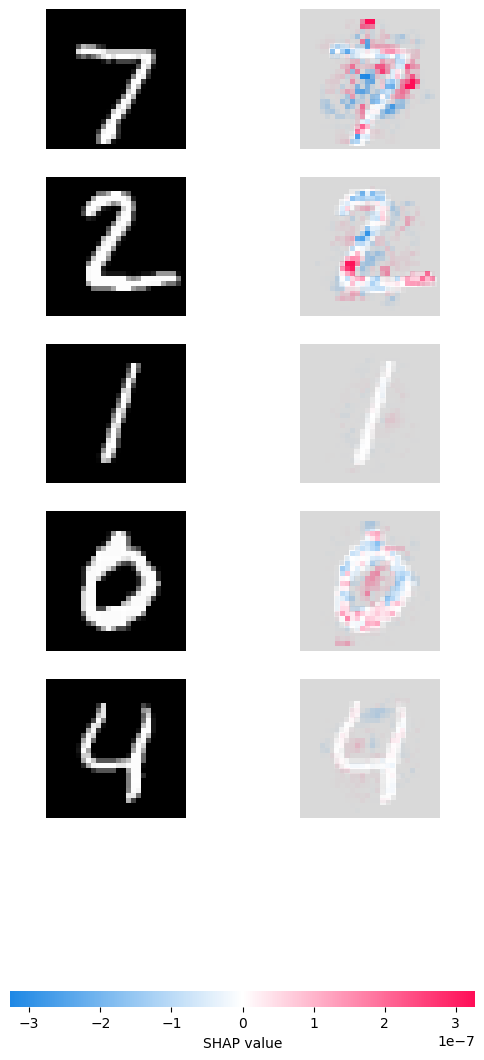

In [6]:
import shap
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import mnist
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ——————————————
# 1) MNIST + DeepExplainer
# ——————————————
# load & normalize
(m_x_train, m_y_train), (m_x_test, m_y_test) = mnist.load_data()
m_x_train = m_x_train.astype('float32') / 255.0
m_x_test  = m_x_test.astype('float32')  / 255.0
m_y_train = m_y_train.astype('int32')
m_y_test  = m_y_test.astype('int32')

# build & train
mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
mlp.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
mlp.fit(m_x_train, m_y_train,
        epochs=3, batch_size=128,
        validation_data=(m_x_test, m_y_test))

# explain a handful of images
bg = m_x_train[np.random.choice(len(m_x_train), 100, replace=False)]
deep_exp = shap.DeepExplainer(mlp, bg)
sv_deep = deep_exp.shap_values(m_x_test[:5])
shap.image_plot(sv_deep, m_x_test[:5])

/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

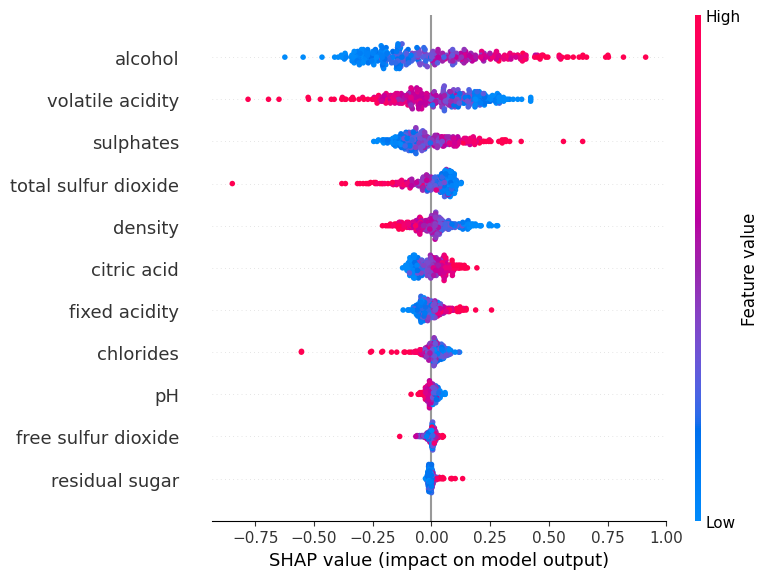

In [7]:
# ——————————————
# 2) Wine + LinearExplainer
# ——————————————
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/"
    "wine-quality/winequality-red.csv",
    sep=";"
)
X, y = df.drop("quality", axis=1), df["quality"]

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scale for linear model
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train).astype('float32')
X_test_s  = scaler.transform(X_test).astype('float32')
y_train   = y_train.astype('float32')
y_test    = y_test.astype('float32')

# train & explain
lin = LinearRegression().fit(X_train_s, y_train)
lin_exp = shap.LinearExplainer(
    lin, X_train_s,
    feature_perturbation="correlation_dependent"
)
sv_lin = lin_exp.shap_values(X_test_s)
shap.summary_plot(sv_lin, X_test_s, feature_names=X.columns)


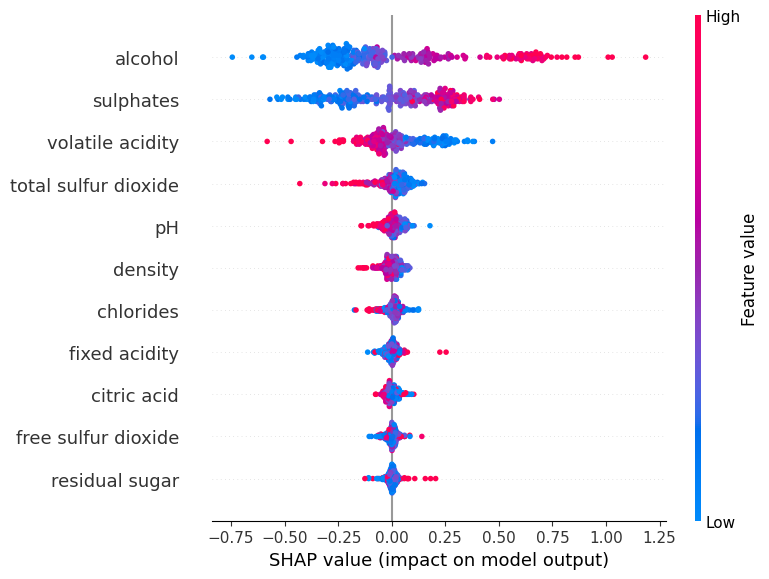

In [8]:
# ——————————————
# 3) Wine + TreeExplainer
# ——————————————
# no scaling needed here
rf = RandomForestRegressor(n_estimators=100, random_state=42) \
        .fit(X_train, y_train)
tree_exp = shap.TreeExplainer(rf)
sv_tree = tree_exp.shap_values(X_test)
shap.summary_plot(sv_tree, X_test, feature_names=X.columns)